In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin,cos,arcsin,sqrt,abs,pi,log10,exp
from scipy.fftpack import fft,ifft

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
%matplotlib inline

#obspy
from obspy import UTCDateTime
from obspy import read
from obspy import read_inventory

from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

from obspy.core.stream import Stream
from obspy.core.event import read_events
from obspy.core.inventory.inventory import read_inventory
from obspy.core.util import Enum

from obspy.core.event.magnitude import StationMagnitude

from obspy.clients.neic import Client as nClient
from obspy.clients.fdsn import Client as fdsnClient

from obspy.geodetics.base import locations2degrees as l2d
from obspy.geodetics.base import degrees2kilometers as d2km
from obspy.geodetics.base import kilometers2degrees as km2d
from obspy.geodetics.base import gps2dist_azimuth as ll2az

from obspy.core.inventory.response import ResponseListElement as amplitude

from obspy.signal.filter import bandpass

#rtergpy
from rtergpy.waveforms import get_respinv, getwaves, loadwaves, process_waves, trstat2pd
from rtergpy.run import defaults, event, etime2name

from locale import setlocale
from scipy.fftpack import fft,ifft
from scipy.stats import gmean 
from tqdm import tqdm
from compress_pickle import dump as cpkldump # reading/writing compressed pickles
from compress_pickle import load as cpklload # reading/writing compressed pickles

In [ ]:
# read ANSS data in from file and dissect the variable comments

Defaults=defaults()
Event=event()
Defaults.src='RASPISHAKE'
Event.newData=False 
Event.ecount='00'
edateold=""
ANSS=pd.read_csv('ANSS_data.txt', sep='\s+', comment="#")
for index, EQ in ANSS.iterrows():
    eloc = [EQ.LAT,EQ.LONG,EQ.DEPTH] 
    year,mo,dd = EQ.DATE.split('/')
    hh,mn,sec = EQ.TIME.split(':')
    etime=(UTCDateTime(int(year),int(mo),int(dd),int(hh),int(mn),float(sec)))
    # iterate ecount
    if EQ.DATE == edateold:
        Event.ecount=str(int(Event.ecount)+1).zfill(2)
    else:
        Event.ecount='00'
    edateold=EQ.DATE
    Event.eventname=etime2name(etime,ecount=Event.ecount)
    Event.origin=[eloc,etime]
    Event.focmech=[EQ.STK, EQ.DP, EQ.RKE] # phi,delta,lmbda

    print("\n\n"+Event.eventname+" ===============================")
    try:
        src2ergs(Defaults=Defaults,Event=Event)
    except:
        print("ERROR: running on "+Event.eventname+" failed!!!!\n\n")

In [2]:
Defaults=defaults()
Event=event()

Defaults.src ="RASPISHAKE"
src = Defaults.src 

Defaults.network ="AM"
network = Defaults.network

Defaults.chan ="EHZ"
chan = Defaults.chan

Defaults.stationrange=[1.,10.]
rads = Defaults.stationrange

Event.eloc = [18.4578,-73.3389,10]
eloc = Event.eloc

Event.etime = UTCDateTime(2022,1,24,13,16,23.425)
etime = Event.etime

Event.origin =[eloc,etime]
Event.ecount ='00'
Event.iter ='RS'
Event.eventname = etime2name(etime,ecount=Event.ecount)

# getting inventory

inventory = get_respinv(network,eloc,etime,rads,chan,src)
print(inventory)

Inventory created at 2023-06-15T20:30:58.989164Z
	Sending institution: SeisComP (RaspberryShake)
	Contains:
		Networks (1):
			AM
		Stations (28):
			AM.R0306 (Raspberry Shake Citizen Science Station)
			AM.R095E (Raspberry Shake Citizen Science Station)
			AM.R17FC (Raspberry Shake Citizen Science Station)
			AM.R2974 (Raspberry Shake Citizen Science Station)
			AM.R2C45 (Raspberry Shake Citizen Science Station)
			AM.R34A9 (Raspberry Shake Citizen Science Station)
			AM.R4802 (Raspberry Shake Citizen Science Station)
			AM.R4DB9 (Raspberry Shake Citizen Science Station)
			AM.R4EEE (Raspberry Shake Citizen Science Station)
			AM.R54B1 (Raspberry Shake Citizen Science Station)
			AM.R6324 (Raspberry Shake Citizen Science Station)
			AM.R804D (Raspberry Shake Citizen Science Station)
			AM.R976A (Raspberry Shake Citizen Science Station)
			AM.RA08A (Raspberry Shake Citizen Science Station)
			AM.RA887 (Raspberry Shake Citizen Science Station)
			AM.RA9CF (Raspberry Shake Citizen Scienc

In [3]:
# getting waveforms
Event.newData = False  # False means locally stored

if Event.newData:
    print("Getting waveforms")
    #st,df=getwaves(eloc,etime,pwindow=Def.waveparams[1],rads=Def.stationrange)
    st,df=getwaves(Defaults=Defaults,Event=Event)
else:
    print("Loading locally stored waveforms")
    try:
        st,df=loadwaves(Defaults=Defaults,Event=Event) 
    except:
        print("Couldn't load data for "+eventname+". Attempting to download:")
        st,df=getwaves(Defaults=Defaults,Event=Event)
if len(st) == 0:
    raise Exception("ERROR: No waveforms retreived.") 

Loading locally stored waveforms


In [7]:
# record following: 
# for each trace: Station Name, stat, loc, chan, time, freq, mag, distance, dist degrees, az, backaz, 
# for each Event (st): loc, depth, origin time, magnitude

#Event.Mw #populate from catalog
#Event.Me #we calculate

eventInformation = df.head()
eventInformation

,eventname,iteration,etime,eloc,network,chan,stationrange,pwindow,modtime,eventdir,inventory
0,2022012400,RS,2022-01-24T13:16:23.425000Z,"[18.4578, -73.3389, 10]",AM,EHZ,"[1.0, 10.0]","[-60, 300]",2023-05-14T15:00:05.951109Z,/Users/hkunwer/Documents/research/EQenergy/eve...,"(((Channel 'EHZ', Location '00' \n\tTime range..."


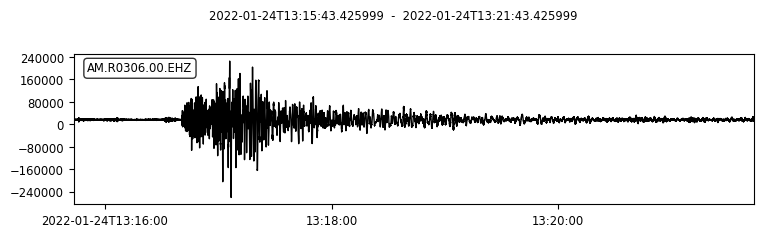

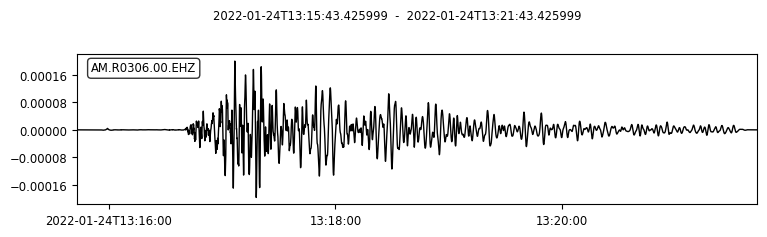

In [8]:
# filter for instrument response and taper

taper=0.05

stp=st.copy()  # create backup
# process data
stp.detrend(type='polynomial', order=5) # pre-instrument removal
stp.taper(taper)
stp.remove_response(output="DISP")
stp.detrend(type='polynomial', order=5) # post-instrument removal
stp.taper(taper)

# check to see if it worked
st[0].plot();
stp[0].plot();

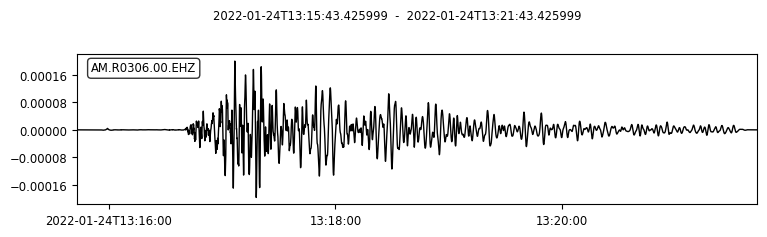

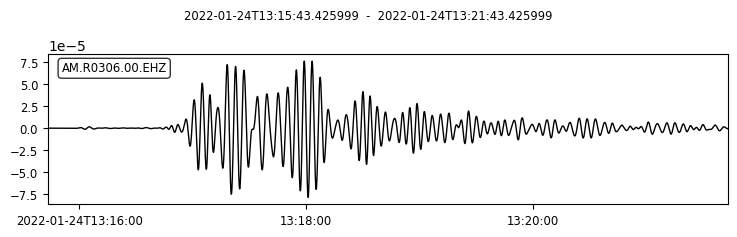

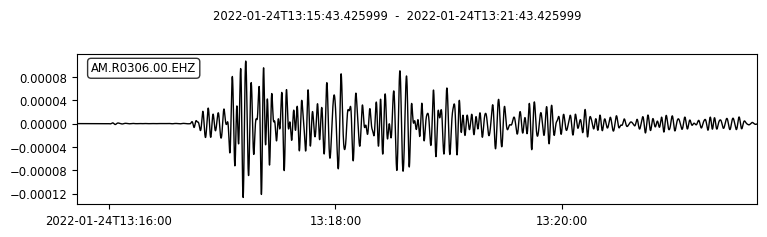

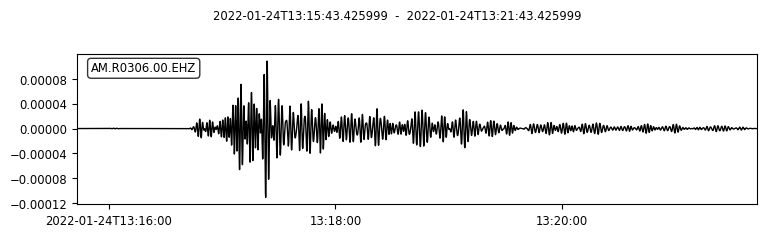

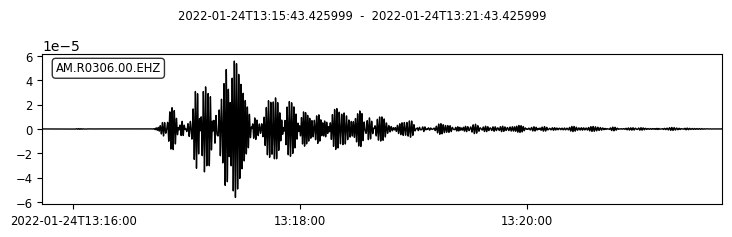

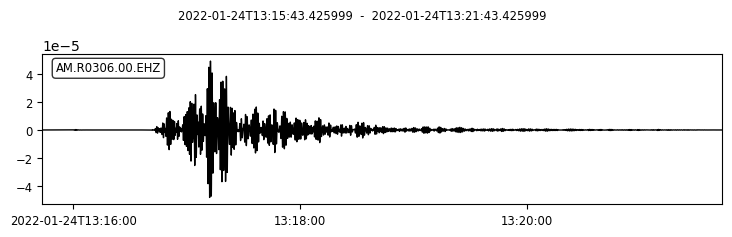

In [9]:
# process each individual frequency band in a bandpass using .filter
# frequency bands of 0.1-0.25, 0.25-0.5, 0.5-0.75, 0.75-1, 1-1.5

freqs = ([0.1,0.25],[0.25,0.5],[0.50,0.75],[0.75,1],[1,1.5])

# freq1 band = 0.1-0.25,
stp_freq1 = stp.copy()
stp_freq1.filter("bandpass",freqmin=0.10 , freqmax=0.25)

# freq2 band = 0.25-0.5,
stp_freq2 = stp.copy()
stp_freq2.filter("bandpass", freqmin=0.25, freqmax=0.50)

# freq3 band = 0.5-0.75,
stp_freq3 = stp.copy()
stp_freq3.filter("bandpass", freqmin=0.50, freqmax=0.75)

# freq4 band = 0.75-1.
stp_freq4 = stp.copy()
stp_freq4.filter("bandpass", freqmin=0.75, freqmax=1.0)

# freq5 band = 0.75-1.
stp_freq5 = stp.copy()
stp_freq5.filter("bandpass", freqmin=1, freqmax=1.25)

stp_freqs = (stp_freq1,stp_freq2,stp_freq3,stp_freq4,stp_freq5)

stp[0].plot();
image = plt.savefig('MaxAmps_'+eventID+'.png') 
stp_freq1[0].plot();
stp_freq2[0].plot();
stp_freq3[0].plot();
stp_freq4[0].plot();
stp_freq5[0].plot();

In [18]:
# define function for max amp for all traces in all selected frequency bands in freqs

def freqmaxes(trace, freqs):
    
    data = trace.data                           # the actual data
    samp = data.shape[-1]                       # number of sample point
    delta = trace.stats.delta                  # sample spacing 
    time = trace.times()                       # time axis 

    # ---- compute fft for our data
    fftdata = np.fft.rfft(data, n=samp)

    # ---- Fdat has real and complex part, to compute power spectrum we take the
    fftdata_abs = np.abs(fftdata)

    # ---- compute x-axis in frequency-domain for plotting
    xf = np.linspace(0.0, 1.0/(2.0*delta), int(samp/2)+1)

    maxamps = []
    idx_of_max_amps = []
    
    for freq in freqs: 
        #argmin find specific position here
        idx_of_min_freq = (np.abs(xf-freq[0])).argmin()
        idx_of_max_freq = (np.abs(xf-freq[1])).argmin()
        
        fftdata_abs_slice = fftdata_abs[idx_of_min_freq:idx_of_max_freq]
        
        # ---- get the max value of amplitude spectrum
        maxamp = fftdata_abs_slice.max()
        idx_of_max_amp = int(np.where(fftdata_abs_slice == maxamp) + idx_of_min_freq)
        maxamps.append(1.0/samp * maxamp)
        idx_of_max_amps.append(idx_of_max_amp)
    
    return maxamps, idx_of_max_amps, xf

In [19]:
# testing max amplitude function created on one trace of stp_freq1
maxamps, idx_of_max_amps, xf = freqmaxes(stp_freq1[0], freqs)
print(maxamps, idx_of_max_amps, xf)

[4.4174823131022625e-06, 2.700613202945242e-06, 3.066221250143393e-08, 2.2519703586025242e-09, 6.177952751023517e-10] [79, 90, 180, 270, 372] [0.00000000e+00 2.77777778e-03 5.55555556e-03 ... 4.99944444e+01
 4.99972222e+01 5.00000000e+01]


In [21]:
# use function to get maxamps for all traces in one frequency band
# compare the plots formed from the function above with previous tests in Appendix below

ALLmaxamps, ALLidx_of_max_amps, trname = [], [], []

for tr in stp_freq1:
        
    # print(f"Now processing trace {tr}")
    maxamps, idx_of_max_amps, xf = freqmaxes(tr, freqs)
    # print(maxamps, idx_of_max_amps) # to test if it worked
    ALLmaxamps.append(maxamps)
    ALLidx_of_max_amps.append(idx_of_max_amps)
    trname.append(tr)
    frq_max_amp = xf[idx_of_max_amps]
    
#df = pd.DataFrame({"trace":trname, "maxamps":ALLmaxamps, "idx of max amps":ALLidx_of_max_amps})             

In [25]:
table = pd.DataFrame({"trace":trname, "maxamps":ALLmaxamps, "idx of max amps":ALLidx_of_max_amps, "fr"})
print(table)

                                               trace  \
0  (0.0, -2.1542175189643172e-24, -2.723861846451...   
1  (0.0, 1.041706350167683e-24, 1.257890026791222...   
2  (0.0, -2.5589170559451525e-24, -3.058499392302...   
3  (0.0, 8.439212875191935e-24, 1.010371435479866...   
4  (0.0, -9.383088924046018e-23, -1.1232979829477...   
5  (0.0, 1.2760194435630901e-15, 1.52772529964227...   
6  (0.0, -1.5076159980588098e-24, -1.812902361651...   
7  (0.0, -6.540293501113301e-24, -7.7486371414427...   
8  (0.0, 9.70538526151727e-24, 1.1614154623595238...   

                                             maxamps          idx of max amps  
0  [4.4174823131022625e-06, 2.700613202945242e-06...  [79, 90, 180, 270, 372]  
1  [3.005276812068665e-07, 1.6361616971851195e-07...  [82, 92, 184, 271, 360]  
2  [3.608987955070632e-07, 1.2207191638486493e-07...  [80, 90, 183, 274, 370]  
3  [4.4244657211684597e-07, 2.1422070398879575e-0...  [71, 90, 185, 281, 368]  
4  [3.6478248856632903e-06, 8.419075517

In [ ]:
#terrible tuples :(

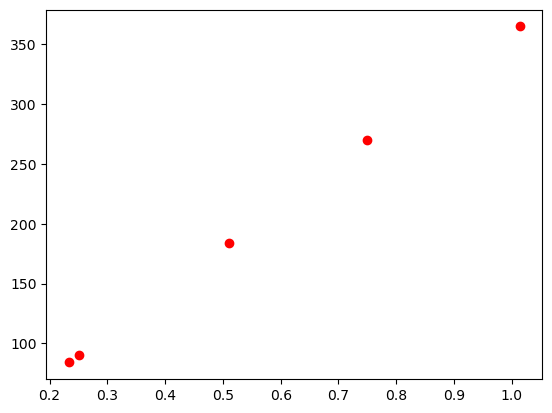

In [26]:
plt.scatter(frq_max_amp, idx_of_max_amps, color='red')

In [ ]:
# APPENDIX? below is amp tests from before used to make our function above. 
# Keeping incase I need to compare to plots above, will remove later.

In [138]:
# max amp for one trace at 0-0.25Hz
trace1 = stp_freq1[0]
data1 = trace1.data                           # the actual data
samp1 = data1.shape[-1]                       # number of sample point
delta1 = trace1.stats.delta                  # sample spacing 
time1 = trace1.times()                       # time axis 

# ---- compute fft for our data
fftdata1 = np.fft.rfft(data1, n=samp1)

# ---- Fdat has real and complex part, to compute power spectrum we take the
fftdata_abs1 = np.abs(fftdata1)

# ---- compute x-axis in frequency-domain for plotting
xf1 = np.linspace(0.0, 1.0/(2.0*delta1), int(samp1/2)+1)

# ---- get the max value of amplitude spectrum
idx_of_max_amp1 = np.where(fftdata_abs1 == fftdata_abs1.max()) # find the index of max amplitudes

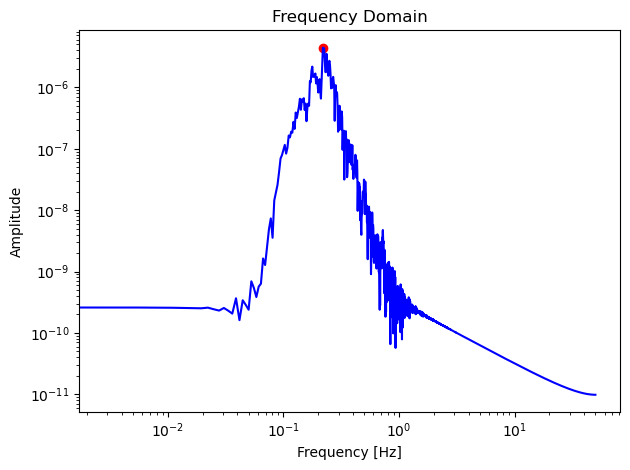

In [139]:
plt.title('Frequency Domain')
plt.plot(xf1, 1.0/samp1 * fftdata_abs1, color='b', linewidth=1.5) # NOTICE the nor
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
frq_max_amp1 = xf1[idx_of_max_amp1]
amp_max_amp1 = 1.0/samp1 * fftdata_abs1[idx_of_max_amp1]
plt.scatter(frq_max_amp1, amp_max_amp1, color='red')
freqband1 = plt.show()

In [141]:
# max amp for one trace at 0.75-1.0Hz
trace4 = stp_freq4[0]
data4 = trace4.data                           # the actual data
samp4 = data4.shape[-1]                       # number of sample point
delta4 = trace4.stats.delta                  # sample spacing 
time4 = trace4.times()                       # time axis 

# ---- compute fft for our data
fftdata4 = np.fft.rfft(data4, n=samp4)

# ---- Fdat has real and complex part, to compute power spectrum we take the
fftdata_abs4 = np.abs(fftdata4)

# ---- compute x-axis in frequency-domain for plotting
xf4 = np.linspace(0.0, 1.0/(2.0*delta4), int(samp4/2)+1)

# ---- get the max value of amplitude spectrum
idx_of_max_amp4 = np.where(fftdata_abs4 == fftdata_abs4.max()) # find the index of max amplitudes

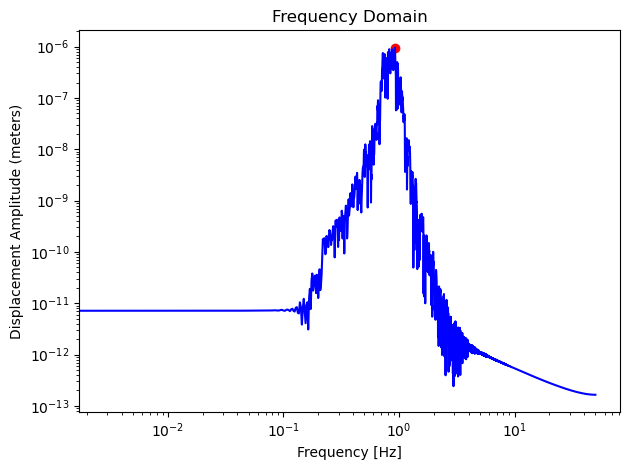

<Figure size 640x480 with 0 Axes>

In [142]:
plt.title('Frequency Domain')
plt.plot(xf4, 1.0/samp4 * fftdata_abs4, color='b', linewidth=1.5) 
plt.xlabel('Frequency [Hz]')
plt.ylabel('Displacement Amplitude (meters)')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
frq_max_amp4 = xf2[idx_of_max_amp4]
amp_max_amp4 = 1.0/samp * fftdata_abs4[idx_of_max_amp4]
plt.scatter(frq_max_amp4, amp_max_amp4, color='red')
plt.show()
plt.savefig('fft_0.75-1Hz.png')

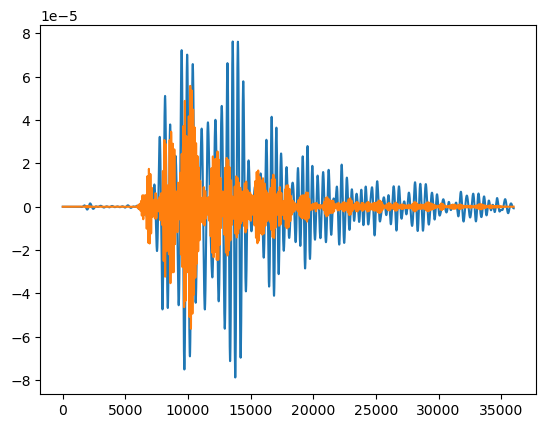

In [143]:
plt.plot(stp_freq1[0].data)
plt.plot(stp_freq4[0].data)